In [2]:
# BASIC LIBS

# data
import pandas as pd
import numpy as np

import geopandas as gpd
import contextily as ctx
from pyproj import CRS

# stat significance
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
%config InlineBackend.figure_format = 'retina'


# JUPYTER CONFIG
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# helper consts
THOUSAND = 1000
MILLION = 1000000

# DATA

## TRIPS

### load

In [175]:
df_trips_initial = pd.read_csv('./data/georgia_od_data/GDOT_2019_09_large.csv')

In [176]:
df_sample = df_trips_initial

In [177]:
df_sample.columns[1:20]

Index(['month', 'origin_zone_id', 'destination_zone_id', 'origin_zone_name',
       'destination_zone_name', 'origin_state', 'destination_state',
       'origin_flag', 'destination_flag', 'day_type', 'avg_linked_trips',
       'avg_unlinked_trips', 'avg_tours', 'total_linked_trips',
       'total_unlinked_trips', 'total_tours', 'hour_00', 'hour_01', 'hour_02'],
      dtype='object')

### how we define trips

In [178]:
df_sample_ = df_sample.rename({
    "origin_zone_id":"ORIG", 
    "destination_zone_id":"DEST",

}, axis=1)

# removing from areas for now since i dont have populations for them and that creates problems
df_sample_ = df_sample_.query("destination_state == 'GA' and origin_state == 'GA'")

df_sample_ = df_sample_[["ORIG", "DEST", "destination_state", "origin_state", "total_linked_trips", "total_unlinked_trips",'purpose_hbw', 'purpose_hbo', 'purpose_wbo', 'purpose_obo']]
df_sample_["TRIPS_HOMEBASED"] = df_sample_.purpose_hbw + df_sample_.purpose_hbo
df_sample_ = df_sample_[["ORIG", "DEST", "TRIPS_HOMEBASED", "origin_state", "destination_state"]]

df_sample_["ORIG"] = df_sample_["ORIG"].astype(str)
df_sample_["DEST"] = df_sample_["DEST"].astype(str)

In [179]:
df_sample_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3314270 entries, 20583 to 3541626
Data columns (total 5 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   ORIG               object
 1   DEST               object
 2   TRIPS_HOMEBASED    int64 
 3   origin_state       object
 4   destination_state  object
dtypes: int64(1), object(4)
memory usage: 151.7+ MB


### POTENTIAL SITES SET

#### Stage 1

In [205]:
incoming = df_sample_.groupby(['DEST', 'destination_state']).agg({"TRIPS_HOMEBASED":"sum"}).reset_index()
outcoming = df_sample_.groupby('ORIG').agg({"TRIPS_HOMEBASED":"sum"}).reset_index()

df_area_traffic_volume = incoming.merge(outcoming, left_on="DEST", right_on="ORIG", how = "left").dropna()
df_area_traffic_volume['traffic_volume'] = df_area_traffic_volume['TRIPS_HOMEBASED_x'] + df_area_traffic_volume['TRIPS_HOMEBASED_y']
df_area_traffic_volume = df_area_traffic_volume.drop(columns = ['ORIG']).rename({'DEST':'area', 'TRIPS_HOMEBASED_x':'incoming', 'TRIPS_HOMEBASED_y':'outcoming'}, axis = 1)

df_area_traffic_volume = (
df_area_traffic_volume
    .query("destination_state == 'GA'")
    .sort_values('traffic_volume', ascending=False)
)

# df_area_traffic_volume.traffic_volume.quantile(0.9)

In [206]:
NUMBER_OF_AREAS = df_area_traffic_volume.area.nunique()
POTENTIAL_SITES_NUMBER = int(NUMBER_OF_AREAS * 0.2)

print(NUMBER_OF_AREAS)
print('Number_of_potential sites to pick: ', POTENTIAL_SITES_NUMBER)

P = set(df_area_traffic_volume.head(POTENTIAL_SITES_NUMBER).area)

7441
Number_of_potential sites to pick:  1488


#### Stage 2 underserved

1. COVERAGE SATURATION WITH STAGE 1 Ps
2. get undercovered area
3. calculate traffic again the same away but only on the sample of undercovered areas

In [207]:
# COVERAGE SATURATION WITH STAGE 1 Ps
# 

# existing_Ps: Set of existing Ps
# Example existing Ps
existing_Ps = P
# trips_dict: Dictionary with keys as (P, A) tuples and values as trips (its calculated for newly sample Ps on the stage after)


# Step 1: Convert trips_dict to DataFrame
# ---------------------------------------
# Create a list of tuples from trips_dict items
trips_data = list(trips_dict.items())

# Convert to DataFrame
trips_df = pd.DataFrame(trips_data, columns=['P_A', 'trips'])

# Split 'P_A' into separate 'P' and 'A' columns
trips_df[['P', 'A']] = pd.DataFrame(trips_df['P_A'].tolist(), index=trips_df.index)

# Display the trips_df for verification
# print("Trips DataFrame:")
# print(trips_df)
# print("\n")

# Step 2: Filter Trips to Include Only Existing Ps
# -------------------------------------------------
filtered_trips_df = trips_df[trips_df['P'].isin(existing_Ps)]

# Display the filtered_trips_df for verification
# print("Filtered Trips DataFrame (Only Existing Ps):")
# print(filtered_trips_df)
# print("\n")

# Step 3: Aggregate Trips by Area to Compute Traffic
# ---------------------------------------------------
# Group by 'A' and sum the 'trips' to get 'traffic'
traffic_df = filtered_trips_df.groupby('A')['trips'].sum().reset_index()

# Rename columns for clarity
traffic_df.rename(columns={'A': 'area_id', 'trips': 'traffic'}, inplace=True)

# Step 4: Merge Aggregated Traffic with df_demand
# -----------------------------------------------
# Merge df_demand with traffic_df on 'area_id'
df_demand = (
    gdf_block_groups_with_population[['full_id', 'area_demand']]
    .rename({'full_id':'area_id', 'area_demand':'demand'}, axis = 1)
)
df_demand = df_demand.merge(traffic_df, on='area_id', how='left')

# Step 5: Handle Missing Values in 'traffic'
# ------------------------------------------
# Replace NaN values in 'traffic' with 0 (indicating no incoming trips from existing Ps)
df_demand['traffic'] = df_demand['traffic'].fillna(0).astype(int)


df_demand['saturation'] = df_demand.traffic / df_demand.demand * 100
df_demand = df_demand.sort_values(["saturation"], ascending=False)


saturation_quantile = df_demand.saturation.quantile(0.45)
df_underverved_areas = df_demand.query("saturation < @saturation_quantile").sort_values(["demand"], ascending=False)

undercovered_ids_set = set(df_underverved_areas.area_id.to_list())

In [208]:
# we still include noncovered areas when choosing new Ps 
# we just dont use those areas for traffic calculation
incoming_undercovered = (
    df_sample_
    .query("ORIG in @undercovered_ids_set")
    .groupby(['DEST', 'destination_state'])
    .agg({"TRIPS_HOMEBASED":"sum"}).reset_index()
)
outcoming_undercovered = (
    df_sample_
    .query("DEST in @undercovered_ids_set")
    .groupby('ORIG')
    .agg({"TRIPS_HOMEBASED":"sum"}).reset_index()
)

df_area_traffic_volume_undercovered = incoming_undercovered.merge(outcoming_undercovered, left_on="DEST", right_on="ORIG", how = "left").dropna()
df_area_traffic_volume_undercovered['traffic_volume'] = df_area_traffic_volume_undercovered['TRIPS_HOMEBASED_x'] + df_area_traffic_volume_undercovered['TRIPS_HOMEBASED_y']
df_area_traffic_volume_undercovered = df_area_traffic_volume_undercovered.drop(columns = ['ORIG']).rename({'DEST':'area', 'TRIPS_HOMEBASED_x':'incoming', 'TRIPS_HOMEBASED_y':'outcoming'}, axis = 1)

df_area_traffic_volume_undercovered_sorted = (
df_area_traffic_volume_undercovered
    .query("area not in @P")
    .query("destination_state == 'GA'")
    .sort_values('traffic_volume', ascending=False)
)

In [209]:
df_area_traffic_volume_undercovered_sorted

,area,destination_state,incoming,outcoming,traffic_volume
7403,133159604002,GA,106511,97839,204350
6852,132679504023,GA,102876,99440,202316
5123,131414804001,GA,96735,102915,199650
5127,131414804005,GA,97830,101792,199622
5811,131899502001,GA,123169,75509,198678
...,...,...,...,...,...
5706,131839800001,GA,1137,237,1374
3353,131171306111,GA,390,981,1371
4447,131350501212,GA,685,476,1161
4440,131350501182,GA,114,896,1010


In [210]:
STAGE_2_SITES_NUMBER = int(POTENTIAL_SITES_NUMBER * 0.33)

print(NUMBER_OF_AREAS)
print('Number_of_potential sites picked 1st stage: ', POTENTIAL_SITES_NUMBER)

P_2 = set(df_area_traffic_volume_undercovered_sorted.head(STAGE_2_SITES_NUMBER).area)
print('Number_of_potential sites picked 2nd stage: ', STAGE_2_SITES_NUMBER)

P = P | P_2
print('Number_of_potential sites picked total: ', len(P))

7441
Number_of_potential sites picked 1st stage:  1488
Number_of_potential sites picked 2nd stage:  491
Number_of_potential sites picked total:  1979


### bi-directional -> one directional

In [211]:

"""
Optimized function to calculate trips dictionary for a subset of origins (P),
including only trips that either begin or end at P.

Args:
    df (pd.DataFrame): DataFrame with columns ["ORIG", "DEST", "TRIPS_HOMEBASED"].
    P (set): Subset of ORIG values.
    
Returns:
    dict: Dictionary with keys (P, ORIG) and values as the sum of P -> ORIG and ORIG -> P trips.
"""
df = df_sample_

# Filter the DataFrame to include only rows where ORIG or DEST is in P
df_filtered = df[(df["ORIG"].isin(P)) | (df["DEST"].isin(P))]

# Group by (ORIG, DEST) and sum TRIPS_HOMEBASED
grouped = df_filtered.groupby(["ORIG", "DEST"])["TRIPS_HOMEBASED"].sum()

# Convert grouped data to a dictionary for fast lookups
trip_lookup = grouped.to_dict()

# Initialize the trips dictionary
trips_dict = {}

# Calculate the sum of P -> ORIG and ORIG -> P for all pairs
for p in P:
    for orig in df_filtered["ORIG"].unique():
        # Get P -> ORIG
        p_to_orig = trip_lookup.get((p, orig), 0)
        
        # Get ORIG -> P
        orig_to_p = trip_lookup.get((orig, p), 0)
        
        # Update the dictionary with the sum
        trips_dict[(p, orig)] = p_to_orig + orig_to_p
    

# Keep only non-zero values in trips_dict
trips_dict = {key: value for key, value in trips_dict.items() if value != 0}


In [212]:
# trips_dict now is P -> A = P -> A + A -> P
trips_dict
1

1

In [213]:
len({el[1] for el in trips_dict.keys()})

7441

## AREAS SET

In [215]:
temp = df_sample_
A = set(temp.ORIG.unique()) | set(temp.DEST.unique())

In [216]:
len(A)

7441

## AREAS DEMAND

### infer areas (block groups) populations from tracts (NA)
it works but ids now matched and we could just merge, leave for now since it still does the job

In [3]:
gdf_block_groups_shapefiles = gpd.read_file(r"./data/georgia_bg_shapefiles/tl_2021_13_bg/tl_2021_13_bg.shp") # competition description is wrong - 2019 does not match
df_population_by_tract = pd.read_csv('./data/population_by_tract_2021.csv')

# run only with df load, since it shortens str
df_population_by_tract = df_population_by_tract.rename({"Geographic ID for geographic unit":"GEOID", "# Total population, 2021":"POP"}, axis=1)
gdf_block_groups_shapefiles["GEOID"] = gdf_block_groups_shapefiles["GEOID"].str[:-1]

gdf_tracts_shapefiles_2021 = gpd.read_file(r"./data/georgia_tract_data/tl_2021_13_tract/tl_2021_13_tract.shp")

In [218]:
# df_join = (
#     gdf_block_groups_shapefiles
#     [["GEOID", "BLKGRPCE", "geometry"]]
#     .merge(df_population_by_tract[["GEOID", "POP"]].astype(str), on = "GEOID", how = "left")
# )
# df_join.POP.isna().value_counts()

Tract of 40% of block groups is missing!!!  
reason - different year. tracts have changes from 2019 to 2021  
fix:  

In [219]:
gdf_population_by_tract = (
    gdf_tracts_shapefiles_2021
    [["GEOID", "geometry"]]
    .merge(df_population_by_tract[["GEOID", "POP"]].astype(str), on = "GEOID", how = "right")
)
gdf_population_by_tract.POP.astype(int).sum() / MILLION

10.625615

for each block group, assign population of its corresponding tract (block group data have the format of: tract_id, block_group_number, geometry of blockgroup shape; tract data have geomtetry of tract shape) if are of block group coincide well enough with tract area (in many cases it wont coincide perfectly cuz tract shapes have changed (they are from a different year)

write me a code to do it

p.s. No need to infer block group population in a smart way, just assign the tract population (i will transform it to block group population later)

In [220]:
# Load the shapefiles
block_groups_2021 = gdf_block_groups_shapefiles
tracts_2021 = gdf_population_by_tract

# Ensure both GeoDataFrames have the same CRS
block_groups_2021 = block_groups_2021.to_crs(tracts_2021.crs)


tracts_2021['tract_geom'] = tracts_2021['geometry']
# Spatial join: Assign tract data to block groups
block_groups_with_population = gpd.sjoin(
    block_groups_2021[['GEOID', 'BLKGRPCE', 'geometry']], tracts_2021[['GEOID', 'geometry', 'POP', 'tract_geom']], 
    how='left', 
    predicate='intersects'  # Match tracts and block groups based on overlapping areas
)

# Calculate the percentage overlap for cases where multiple tracts intersect a block group
block_groups_with_population['overlap_area'] = block_groups_with_population.geometry.intersection(
    block_groups_with_population['tract_geom']
).area

# Retain only the tract with the largest overlap for each block group

block_groups_with_population['overlap_percent'] = block_groups_with_population.overlap_area / block_groups_with_population.geometry.area * 100
block_groups_with_population['overlap_percent'] = block_groups_with_population['overlap_percent'].apply(lambda x: round(x, 3))
block_groups_with_population = (
    block_groups_with_population
        .sort_values(['GEOID_left', 'BLKGRPCE', 'overlap_percent'], ascending=[True, True, False])
        .drop_duplicates(subset=['GEOID_left', 'BLKGRPCE'])
)


block_groups_with_population = block_groups_with_population.drop(columns=['index_right', 'GEOID_right', 'tract_geom']).rename({'POP':'tract_pop', 'GEOID_left': 'GEOID'}, axis = 1)

In [221]:
#   model.addConstr(saturation_raw[j] == quicksum(served[i, j] for i in P if (i, j) in tr) / c[j], name=f"saturation_raw_{j}")
#                                          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~
#   File "src/gurobipy/linexpr.pxi", line 572, in gurobipy.LinExpr.__truediv__
# ZeroDivisionError: float division

# model can't divide by zero 
# if population is zero its probably missing => replace with the global median for now (todo: interpolate from the neighboring areas)

block_groups_with_population.tract_pop = block_groups_with_population.tract_pop.astype(int)
TEMP_MEDIAN = block_groups_with_population.tract_pop.median()
block_groups_with_population.loc[block_groups_with_population.tract_pop == 0, 'tract_pop'] = TEMP_MEDIAN
block_groups_with_population[block_groups_with_population.tract_pop == 0]

,GEOID,BLKGRPCE,geometry,tract_pop,overlap_area,overlap_percent


In [222]:
# INFERRING BLOCK GROUP POPULATION FROM TRACT
temp = block_groups_with_population.groupby('GEOID')['BLKGRPCE'].count().reset_index()
temp.columns = ['GEOID', 'tract_block_group_count']
block_groups_with_population = block_groups_with_population.merge(temp, on = 'GEOID', how = 'left')

block_groups_with_population['block_group_population_inferred'] = block_groups_with_population.tract_pop.astype(int) / block_groups_with_population.tract_block_group_count

In [223]:
gdf_block_groups_with_population = block_groups_with_population

### bring populations and trips to one dimension

trips per resident = total trips / total population  
trips generated per area = area population * trips per resident
  
we care about
- proportions with real trips per area
- absolute number match with trips amount (sum of trips **we use in the model** == sum of trips of all areas)

BUG: I only calculate existing trips from Ps, not all trips (FIXED)  
now it calculated from df_sample and will be constant respective to number of Ps  

In [231]:
df_sample_.TRIPS_HOMEBASED.sum() / MILLION

611.182098

In [239]:
TRIPS_TOTAL = df_sample_.TRIPS_HOMEBASED.sum()
print('total trips in millions: ', round(TRIPS_TOTAL / MILLION, 2))

POPULATION_TOTAL = gdf_block_groups_with_population.block_group_population_inferred.sum()
print('total population in millions: ', round(POPULATION_TOTAL / MILLION, 2))

TRIPS_PER_RESIDENT = TRIPS_TOTAL / POPULATION_TOTAL
print('trips per 1 resident in Georgia: ', round(TRIPS_PER_RESIDENT, 2))

gdf_block_groups_with_population['area_demand'] = gdf_block_groups_with_population.block_group_population_inferred * TRIPS_PER_RESIDENT


# reorder columns
gdf_block_groups_with_population = gdf_block_groups_with_population[[
    'GEOID', 'BLKGRPCE', 
    'area_demand', 
    'block_group_population_inferred', 'tract_pop', 'overlap_area',
    'overlap_percent', 'tract_block_group_count', 'geometry']]

total trips in millions:  611.18
total population in millions:  10.67
trips per 1 resident in Georgia:  57.26


In [240]:
print(TRIPS_TOTAL / MILLION)
print(gdf_block_groups_with_population.area_demand.sum() / MILLION)
print('double-check that it matches')

611.182098
611.182098
double-check that it matches


In [241]:
# area_demand_dict(geoid + bg number) == A == P == trips keys
gdf_block_groups_with_population['full_id'] = gdf_block_groups_with_population.GEOID + gdf_block_groups_with_population.BLKGRPCE

area_demand_dict = gdf_block_groups_with_population.set_index("full_id")["area_demand"].to_dict()

# EXPORT

In [242]:
trips_export = trips_dict
potential_sites_set_export = P
areas_set_export = A
areas_demand_export = area_demand_dict

## validate

## export

In [243]:
print('- trips:')
print('rows:', len(trips_export))
print()

print('- areas set:')
print('rows:', len(areas_set_export))
print()

print('- potential sites set:')
print('rows:', len(potential_sites_set_export))
print()


print('- areas demand:')
print('rows:', len(areas_demand_export))
print('average demand: ', round(np.mean(list(areas_demand_export.values())), 1))
print()


- trips:
rows: 928564

- areas set:
rows: 7441

- potential sites set:
rows: 1979

- areas demand:
rows: 7446
average demand:  82081.9



In [229]:
import pickle

# Convert sets to lists (JSON does not support sets)
data = {
    "trips": trips_export, 
    "potential_sites": list(potential_sites_set_export), 
    "areas": list(areas_set_export),
    "areas_demand": areas_demand_export,
}

with open("./data/georgia_processed_data/georgia_processed_data.pkl", "wb") as f:
    pickle.dump(data, f)

In [47]:
# # CODE TO IMPORT
# # Load the data from the .pkl file
# with open("./data/georgia_processed_data/trips_sites_areas.pkl", "rb") as f:
#     loaded_data = pickle.load(f)

# print(loaded_data.keys())

# OTHER

### Defining the value from the charger

In [ ]:
TOTAL_COST = 70 * MILLION

In [247]:
COVERAGE = 382299766 # 70 MM

In [248]:
TOTAL_COST / COVERAGE

0.1778708909803518

In [246]:
TOTAL_COST

68000000

### P Traffic (trips) amount

In [ ]:
(df_area_traffic_volume.query("area in @P").traffic_volume.sum()) / MILLION

347.002822

seemingly the same, but trips intersect so they dont cover all the demand

In [ ]:
total_area_capacities = 346349864.36
total_area_capacities / MILLION

346.34986436

In [ ]:
total_area_capacities * 0.62 / MILLION

214.7369159032

<Axes: >

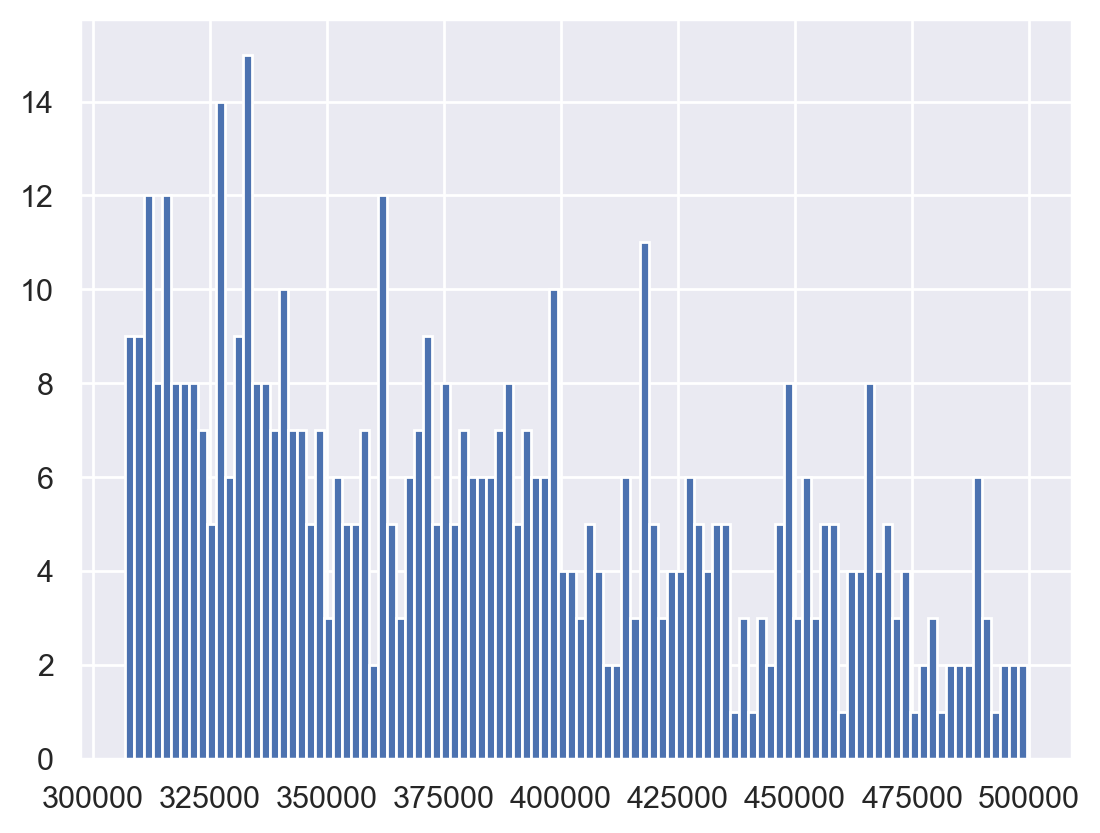

In [ ]:
df_area_traffic_volume.query("area in @P and traffic_volume < 500000").traffic_volume.hist(bins = 100)

### Model gap

In [50]:
coverage = 3400
cur = 2000
gap = 0.05

(cur / coverage * 100) - (cur*(1 - gap) / coverage * 100)

2.941176470588239

## Shapefiles export

In [36]:
# Export GeoDataFrame to a GeoPackage file
gdf_block_groups_with_population.to_file("./data/block_groups_shapefiles_with_population.gpkg", layer="areas", driver="GPKG")


## Model Parameters

In [464]:
# model solves !

In [18]:
# As of 2023, there were approximately 4.7 million plug-in electric vehicles (EVs) in use in the United States. 
# WIKIPEDIA
#  Given that the total number of registered vehicles in the U.S. is around 276 million, EVs constitute about 1.7% of all vehicles on the road.

# It's important to note that while EV sales have been increasing, the overall share of EVs in the total vehicle fleet remains relatively low due to the long 
# lifespan of vehicles and the gradual turnover of the existing fleet.

EV_SHARE = 0.017

DAYS_IN_A_MONTH = 30
HOURS_PER_DAY = 10
CARS_PER_HOUR = 2

# todo: public usecase share
PUBLIC_USECASE_SHARE = 0.07

CHARGING_SPOT_CAPACITY = (DAYS_IN_A_MONTH * HOURS_PER_DAY * CARS_PER_HOUR) / EV_SHARE / PUBLIC_USECASE_SHARE
CHARGING_SPOT_CAPACITY

504201.6806722688

In [43]:
# $1.5 billion
# Atlanta, GA – Governor Brian P. Kemp today announced new details for the historic $1.5 billion investment 
# in transportation infrastructure around the state included in the Amended Fiscal Year 2024 budget.

BUDGET = 100 * MILLION
COST = 300000
CHARGERS = BUDGET / COST
CHARGERS

333.3333333333333

In [58]:
MILLION = 1000000
BUDGET = 100 * MILLION
COST = 150000
CHARGERS = BUDGET / COST
CHARGERS

budgets = range(150, 351, 100)
CAP_SPOT = 350000              
MAX_CHARGERS = 30

In [59]:
[int(budget * MILLION / COST) for budget in budgets]

[1000, 1666, 2333]

In [477]:
gdf_block_groups_with_population.area_demand.mean()

46602.581520279346

In [480]:
np.mean(list(trips_export.values()))

695.1415052195287

## match model data input fromat with data I generate here

In [1]:
from synthetic_data_gen import GENERATE_DATA

# SYNTHETIC
N_AREAS = 10
N_POTENTIAL_SITES = 5
CHARGERS_BUDGET_LIMIT = 15
CAP_SPOT = 200        # Each charging spot serves up to 200 trips
MAX_CHARGERS = 5

A, P, c, tr = GENERATE_DATA(
    N_AREAS,
    N_POTENTIAL_SITES,
    CHARGERS_BUDGET_LIMIT,
    CAP_SPOT,
    MAX_CHARGERS,
    SEED = 43
)


Trips Matrix (Potential Station Sites as rows, Areas as columns):
       Area1  Area2  Area3  Area4  Area5  Area6  Area7  Area8  Area9  Area10
Area1   1043   1057    749    932   1006   1055   1111    809   1063    1021
Area3    763    892    778    749    782   1062   1053    865   1195     998
Area4   1005    959    839    994    793    992    832    825   1096     831
Area5    995    890   1019    980   1086   1022   1001    890    829     854
Area8    895    831    884    951    940    169    283    176    299     165

Area Capacities (c):
          Area1  Area2  Area3  Area4  Area5  Area6  Area7  Area8  Area9  \
Capacity    112    179    158    200    182    985    884    884    935   

          Area10  
Capacity     970  

Constants:
CHARGERS_BUDGET_LIMIT: 15
CAP_SPOT: 200
MAX_CHARGERS: 5


## A and areas demand size mismatch

add area that are perfect match? check initial length

In [300]:
gdf_bg_shp_19 = gpd.read_file(r"./data/georgia_bg_shapefiles/tl_2019_13_bg/tl_2019_13_bg.shp")
gdf_bg_shp_21 = gpd.read_file(r"./data/georgia_bg_shapefiles/tl_2021_13_bg/tl_2021_13_bg.shp")
gdf_bg_shp_24 = gpd.read_file(r"./data/georgia_bg_shapefiles/tl_2024_13_bg/tl_2024_13_bg.shp")

In [309]:
temp = gdf_bg_shp_21

temp_set = set(temp.GEOID.unique())

len(temp_set & A)

7441

In [313]:
len(temp_set & set(df_area_traffic_volume.area.unique()))

7441

In [ ]:
import random
random.sample(list(A), 5)

['131350502224',
 '131759504003',
 '132330101001',
 '132859601022',
 '131350505911']

In [148]:
len(set(areas_demand_export.keys()) & A)

3112

In [ ]:
all_ids_in_trips

In [292]:
len(ad)

5533

In [168]:
inter = set(areas_demand_export.keys()) & A

In [297]:
# gdf_block_groups_with_population.query("full_id in @inter").explore()

In [ ]:
len(set(areas_demand_export.keys()) - A

2421

In [244]:
len(A)

7441

In [242]:
ad = set(areas_demand_export.keys())

In [232]:
d_not = gdf_block_groups_with_population.query("full_id not in @inter").describe()

In [233]:
d_int = gdf_block_groups_with_population.query("full_id in @inter").describe()

In [243]:
len(set(df_area_traffic_volume.area.unique()) & ad)

3112

In [290]:
map1 = (
    gdf_block_groups_with_population
    .merge(df_area_traffic_volume, left_on = 'full_id', right_on = 'area')
    .explore(
        column='traffic_volume',  # The column to base the heatmap on
        cmap='YlOrRd',        # Color map for the heatmap
        scheme='Quantiles',   # Optional: Categorize data (e.g., 'Quantiles', 'EqualInterval')
        legend=True,          # Show a legend
        tiles='CartoDB positron'  # Specify base map tiles
    )
)

# Save the maps to an HTML file
map1.save('./data/maps/traffic_volume_in_not_missing_areas.html')

In [284]:
df_area_traffic_volume

,area,destination_state,incoming,outcoming,traffic_volume
1455,130639800001,GA,1751472,899408.0,2650880.0
1587,130670302783,GA,1499537,843912.0,2343449.0
1178,130590004022,GA,1269898,829934.0,2099832.0
4275,131210119013,GA,869523,474334.0,1343857.0
3455,131210010012,GA,779151,430747.0,1209898.0
...,...,...,...,...,...
476,130299800001,GA,8242,3192.0,11434.0
2367,130890212222,GA,4798,6526.0,11324.0
2842,130899800001,GA,8699,1781.0,10480.0
5887,131919800001,GA,14,2050.0,2064.0


In [245]:
traff_int = (set(df_area_traffic_volume.area.unique()) & ad)

In [250]:
df_area_traffic_volume.query("area in @traff_int").describe() / THOUSAND

,incoming,outcoming,traffic_volume
count,3.112000,3.112000,3.112000
mean,80.484118,79.418824,159.902942
std,85.107072,57.444495,138.382356
min,0.014000,0.325000,1.865000
25%,34.864000,44.099500,80.886000
50%,56.747000,66.357000,124.082500
75%,94.120000,97.910500,192.067250
max,1751.472000,899.408000,2650.880000


In [ ]:
df_area_traffic_volume.query("area not in @traff_int").describe() / THOUSAND

,incoming,outcoming,traffic_volume
count,4.329000,4.329000,4.329000
mean,85.302121,85.940492,171.242613
std,83.136973,54.975743,133.687879
min,3.574000,5.820000,11.324000
25%,36.777000,49.434000,89.075000
50%,59.810000,73.906000,136.731000
75%,103.216000,107.437000,209.588000
max,1499.537000,843.912000,2343.449000


In [295]:
# d_not

In [296]:
# d_int

In [293]:
# gdf_block_groups_with_population.query("full_id in @inter").explore()

In [294]:
idss = {'130670314092', '130670314051'}
# gdf_block_groups_with_population.query("full_id.str.contains('130670314')").explore()

In [276]:
gdf_block_groups_with_population.query("full_id.str.contains('130670314')")[['GEOID', 'BLKGRPCE']]

,GEOID,BLKGRPCE
1404,13067031404,1
1405,13067031404,2
1406,13067031404,3
1407,13067031404,4
1408,13067031405,1
1409,13067031405,2
1410,13067031405,3
1411,13067031405,4
1412,13067031405,5
1413,13067031406,1


In [274]:
{ (int(el[:-1]), int(el[-1:])) for el in A if '130670314' in el }

{(13067031409, 1),
 (13067031409, 2),
 (13067031409, 3),
 (13067031409, 4),
 (13067031410, 1),
 (13067031410, 2),
 (13067031410, 3),
 (13067031411, 1),
 (13067031411, 2),
 (13067031411, 3),
 (13067031412, 1),
 (13067031412, 2),
 (13067031412, 3),
 (13067031413, 1),
 (13067031413, 2),
 (13067031413, 3),
 (13067031414, 1),
 (13067031414, 2),
 (13067031414, 3),
 (13067031415, 1),
 (13067031415, 2),
 (13067031416, 1),
 (13067031416, 2),
 (13067031416, 3),
 (13067031417, 1),
 (13067031417, 2)}

In [158]:
diff = set(areas_demand_export.keys()) - A

In [160]:
diff_n = [ len(id) for id in diff ]

In [162]:
np.mean(diff_n)

12.0

In [150]:
import json
# Export to JSON
with open("areas_demand_export.json", "w") as f:
    json.dump(list(set(areas_demand_export.keys())), f)

In [151]:
import json
# Export to JSON
with open("areas.json", "w") as f:
    json.dump(list(A), f)

In [ ]:
# A is from trips trips od 2019
# area demand is from gdf_block_groups_shapefiles = gpd.read_file(r"./data/block_groups_shapefiles_2019/tl_2019_13_bg.shp")

SyntaxError: invalid syntax (620243760.py, line 1)

In [149]:
# 5500 block group cover the whole georgia so they are exhaustive
len(set(areas_demand_export.keys()) )

5533

In [ ]:
{ key for key in areas_demand_export.keys() if key == '132330101001' }

{'132330101001'}

In [ ]:
areas_demand_export

{'130019501001': 78495.12133245582,
 '130019501002': 78495.12133245582,
 '130019502001': 38104.13080758988,
 '130019502002': 37721.71279466746,
 '130019502003': 38104.13080758988,
 '130019503001': 18310.174458725443,
 '130019503002': 18310.174458725443,
 '130019503003': 33958.71954751085,
 '130019503004': 33958.71954751085,
 '130019504001': 42494.289595939255,
 '130019504002': 42494.289595939255,
 '130019505001': 56949.69048440671,
 '130019505002': 56949.69048440671,
 '130019505003': 56949.69048440671,
 '130039601001': 50800.4088366142,
 '130039601002': 50800.4088366142,
 '130039602001': 70426.10125979278,
 '130039602002': 70426.10125979278,
 '130039602003': 70426.10125979278,
 '130039603001': 66586.62441005168,
 '130059701001': 41285.848675104404,
 '130059701002': 41285.848675104404,
 '130059701003': 41285.848675104404,
 '130059702011': 65699.41462007166,
 '130059702012': 65699.41462007166,
 '130059702013': 65699.41462007166,
 '130059702021': 63772.02783494267,
 '130059702022': 63772.

## total population mismatch (solved)

In [332]:
gdf_block_groups_with_population.block_group_population_inferred.sum() / 1000000

10.625615

In [333]:
gdf_block_groups_with_population.drop_duplicates('GEOID').tract_pop.sum() / 1000000

10.625615

In [523]:
df_population_by_tract.POP.sum() / 1000000

10.625615

In [540]:
map_my = gdf_block_groups_with_population.explore(
    column='tract_pop',  # The column to color shapes by
    cmap='YlOrRd',                # Colormap (e.g., Yellow-Orange-Red)
    legend=True,                  # Show a legend
    tiles='CartoDB positron'      # Base map style
)

In [544]:
tracts_2021.POP = tracts_2021.POP.astype(int)
map_baseline = tracts_2021.explore(
    column='POP',  # The column to color shapes by
    cmap='YlOrRd',                # Colormap (e.g., Yellow-Orange-Red)
    legend=True,                  # Show a legend
    tiles='CartoDB positron'      # Base map style
)

In [ ]:
# Save the maps to an HTML file
# map_my.save('map_my.html')
# map_baseline.save('map_baseline.html')

True

Visually overall trends are the same  
=> using my total for analysis  
trends should be the same